# A Gentle Introduction to Transfer Learning

In [28]:
import sys
import os
import numpy as np
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler, SGD
from torch.autograd import Variable
from torchvision import models
from utils import (get_gpu_name, get_number_processors, plot_pytorch_data_stream, train_model, create_dataset, 
                   available_models)

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())
print("GPU: ", get_gpu_name())

%matplotlib inline
%load_ext autoreload
%autoreload 2

OS:  linux
Python:  3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
PyTorch:  0.2.0_3
Numpy:  1.13.3
Number of CPU processors:  24
GPU:  ['Tesla M60', 'Tesla M60', 'Tesla M60', 'Tesla M60']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
torch.backends.cudnn.benchmark=True # enables cudnn's auto-tuner

In [11]:
MODEL_NAME = 'resnet18'
BATCH_SIZE = 64
SETS = ['train', 'val']
EPOCHS = 25
LR = 0.001
LR_STEP = 0.1
LR_EPOCHS = 7
MOMENTUM = 0.9

## Model and utilities

In [12]:
model_names = available_models()
print(model_names)

['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [13]:
def finetune(dataloaders, model_name, num_epochs, lr, momentum, lr_step, lr_epochs):
    num_class = len(dataloaders['train'].dataset.class_to_idx)
    model_ft = models.__dict__[model_name](pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_class)
    model_ft = model_ft.cuda()
    #loss
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer = SGD(model_ft.parameters(), lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_ft = train_model(dataloaders, model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)
    return model_ft

In [25]:
def freeze_and_train(dataloaders, model_name, num_epochs, lr, momentum, lr_step, lr_epochs):
    num_class = len(dataloaders['train'].dataset.class_to_idx)
    model_conv = models.__dict__[model_name](pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, num_class)
    model_conv = model_conv.cuda()
    #loss
    criterion = nn.CrossEntropyLoss()

    # Observe that only parameters of final layer are being optimized 
    optimizer = SGD(model_conv.fc.parameters(), lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_conv = train_model(dataloaders, model_conv, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)
    return model_conv

## Datasets
We are going to use the dataset [hymenoptera](https://download.pytorch.org/tutorial/hymenoptera_data.zip)

In [15]:
DATA_ROOT = 'data'
HYMENOPTERA_ROOT = os.path.join(DATA_ROOT, 'hymenoptera_data')

In [16]:
data_hymenoptera = create_dataset(HYMENOPTERA_ROOT)

There are 2 clases in the dataset: {'ants': 0, 'bees': 1}
Sets sizes:  {'train': 244, 'val': 153}
Number of items in set train: {0: 123, 1: 121}
Number of items in set val: {0: 70, 1: 83}


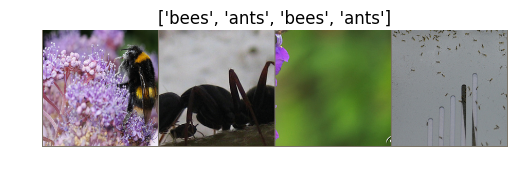

In [17]:
plot_pytorch_data_stream(data_hymenoptera['train'], max_images=4)

In [18]:
model, acc_per_epoch, loss_per_epoch = finetune(data_hymenoptera, MODEL_NAME, EPOCHS, LR, MOMENTUM, LR_STEP, LR_EPOCHS)

Epoch 0/24
----------
train Loss: 0.0270 Acc: 0.4385
val Loss: 0.0190 Acc: 0.6667

Epoch 1/24
----------
train Loss: 0.0157 Acc: 0.7746
val Loss: 0.0105 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.0097 Acc: 0.8852
val Loss: 0.0080 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.0073 Acc: 0.9221
val Loss: 0.0067 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.0065 Acc: 0.9180
val Loss: 0.0063 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.0069 Acc: 0.9262
val Loss: 0.0064 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.0070 Acc: 0.9221
val Loss: 0.0057 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.0046 Acc: 0.9385
val Loss: 0.0056 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.0067 Acc: 0.9180
val Loss: 0.0058 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.0039 Acc: 0.9713
val Loss: 0.0056 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.0047 Acc: 0.9549
val Loss: 0.0057 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.0050 Acc: 0.9426
val Loss: 0.0060 Acc: 0.9346

Ep

In [29]:
model, acc_per_epoch, loss_per_epoch = freeze_and_train(data_hymenoptera, MODEL_NAME, EPOCHS, LR, MOMENTUM, LR_STEP, LR_EPOCHS)

Epoch 1/25
----------
train Loss: 0.0265 Acc: 0.4672
val Loss: 0.0207 Acc: 0.6078

Epoch 2/25
----------
train Loss: 0.0184 Acc: 0.7008
val Loss: 0.0135 Acc: 0.9020

Epoch 3/25
----------
train Loss: 0.0138 Acc: 0.8279
val Loss: 0.0097 Acc: 0.9346

Epoch 4/25
----------
train Loss: 0.0115 Acc: 0.8689
val Loss: 0.0079 Acc: 0.9477

Epoch 5/25
----------
train Loss: 0.0091 Acc: 0.9098
val Loss: 0.0069 Acc: 0.9542

Epoch 6/25
----------
train Loss: 0.0074 Acc: 0.9262
val Loss: 0.0066 Acc: 0.9608

Epoch 7/25
----------
train Loss: 0.0098 Acc: 0.9016
val Loss: 0.0062 Acc: 0.9412

Epoch 8/25
----------
train Loss: 0.0070 Acc: 0.9508
val Loss: 0.0059 Acc: 0.9346

Epoch 9/25
----------
train Loss: 0.0059 Acc: 0.9590
val Loss: 0.0060 Acc: 0.9542

Epoch 10/25
----------
train Loss: 0.0067 Acc: 0.9344
val Loss: 0.0058 Acc: 0.9608

Epoch 11/25
----------
train Loss: 0.0068 Acc: 0.9344
val Loss: 0.0059 Acc: 0.9608

Epoch 12/25
----------
train Loss: 0.0069 Acc: 0.9467
val Loss: 0.0057 Acc: 0.9542

E

In [31]:
len(acc_per_epoch)

25